# Multi-objective Bayesian Optimisation

https://botorch.org/docs/multi_objective
* "The goal in MOBO is learn the Pareto front: the set of optimal trade-offs, where an improvement in one objective means deteriorating another objective."
* "The MC-based acquisition functions support using the sample average approximation for rapid convergence"
* Additionally, variations on ParEGO can be trivially implemented using an augmented Chebyshev scalarization as the objective with an EI-type single-objective acquisition function such as qLogNoisyExpectedImprovement. The get_chebyshev_scalarization convenience function generates these scalarizations.
  
https://botorch.org/tutorials/constrained_multi_objective_bo
Considerations
* BoTorch assumes maximization
  * leave growth rate as it is
  * maximise negative of costs


from: https://botorch.org/tutorials/constrained_multi_objective_bo

"For batch optimization (or in noisy settings), we strongly recommend using NEHVI rather than EHVI [1] because it is far more efficient than EHVI and mathematically equivalent in the noiseless setting." <- but that's hypervolumen...

"Note: EHVI aggressively exploits parallel hardware and is much faster when run on a GPU. See [1] for details."
-> use GPU and run on server

### Function
* The model consists of a list of mono-objective models.
The likelihood at each point is the sum of all (both) GP’s likelihood.
* Acquisition optimisation
  * optimises multiple (2) objectives at once
  * approach used: qNParEGO
    * starts with scalarisation - combine all objectives into a single compound function (augmented chebyshev)
  * random process; possibly slower than qEHVI or qNEHVI
  *
### Concept
Within the function
1. Change the medium composition using BayesOpt
2. For each composition
     1. calculate the cost
     2. find optimal growth rate using FBA
     3. calculate growth/cost (should be maximised)
        * How to prevent that the cost is driven to 0? -> even if it drives growth to 0, it will probably be numerically optimal
3. Return optimal medium composition, growth rate, costs and relationship

# Implementation

In [1]:
# When running in google colab
#pip install cobra

In [2]:
# When running in google colab
#pip install botorch

In [3]:
from cobra.io import load_model

import torch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
# sampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.sampling import sample_simplex

# Acquisition function
from botorch.optim.optimize import optimize_acqf_list
from botorch.optim import optimize_acqf # optimise acquisition function

from botorch.acquisition.logei import qLogExpectedImprovement # assumes noiselessness
from botorch.acquisition.objective import GenericMCObjective

from botorch.utils.transforms import unnormalize, normalize # for normalising media components
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization

import random # for initial data
import json # to save results
import copy # to be able to do deep copies
import numpy as np

### Helper Functions & Plotting

In [4]:
# Plotting functions to be used across notebooks
#%run ../HelperFunctions.ipynb

# same but for .py version
from HelperFunctions import *

In [5]:
# Plotting functions to be used across notebooks
#%run ../Plotting.ipynb

# same but for .py version
from Plotting import *

## BayesOpt

In [6]:
def find_next_candidate_noiseless(medium_tensors_normalised_stacked, cost_tensor, growth_tensor,
                                  bounds_tensors_stacked, n_candidates = 1):
    """
    Finds the next medium composition for which to evaluate cost and optimal growth rate
    * normalises the medium composition between 0,1
    * initialises botorch model (list of SingleTaskGP) and mll
    * calculates posterior mean
    * uses SobolQMCNormalSampler to sample from posterior
    * uses qLogExpectedImprovement acquisition function
    * uses chebyshev_scalarization to create a vector representation of the two objectives (cost mini, growth rate max)
    
    PARAMETERS
    * medium_tensors_normalised_stacked - tensor - all medium compositions previously evaluated, stored as tensors (in order)
    * cost_tensor - tensor - corresponding medium costs
    * growth_tensor - tensor - corresponding growth rates
    * bounds_tensors_stacked - tensors - upper and lower bounds for the values the medium components are allowed to take,
    determines the search space;
    * n_candidates - integer - how many candidates to find at once

    RETURNS
    * candidates[0] - tensor - a tensors with the normalised (0,1) medium composition
    """

    '''parameters and conversion to tensors; normalisation of medium composition to (0,1)'''
    MC_SAMPLES = 256 #256 # Number of Monte Carlo samples in SobolQMCNormalSampler
    n_components = medium_tensors_normalised_stacked.size()[1] # of medium components
    standard_bounds = standard_bounds = torch.tensor([[0.0] * n_components, 
                                                      [1.0] * n_components]).to(**tkwargs) # normalised bounds for medium composition
    # large values -> slower but possibly better accuracy
    NUM_RESTARTS =  5 #10 # Number of restarts for acquisition function optimisation
    RAW_SAMPLES = 512 # 1024 # Number of raw samples for initialisation of acquisition optimisation


    '''finding the new candidate'''
    # initialise GP model and marginal likelihood (mll)
    mll, model = initialise_model(
        medium_tensors_normalised_stacked, 
        cost_tensor, 
        growth_tensor)
    
    fit_gpytorch_mll(mll) # # Fit the model using the maximum marginal likelihood

    # Compute the posterior mean for the given medium_tensors_stacked using the model
    with torch.no_grad():
        posterior = model.posterior(medium_tensors_normalised_stacked).mean

    # Set up a Sobol quasi-Monte Carlo sampler for sampling from the posterior
    # The sample_shape should correspond to the shape of the posterior samples needed
    sampler = SobolQMCNormalSampler(sample_shape = torch.Size([MC_SAMPLES]), seed = MC_SAMPLES)

    acq_fun_list = [] # List to hold acquisition functions for each candidate
    # Loop to generate acquisition functions for each candidate
    for _ in range(n_candidates):
        # Sample weights from the simplex for Chebyshev scalarization
        weights = sample_simplex(2, **tkwargs).squeeze() # using 2 weights for scalarization (cost and growth)

        # Compute the scalarised objective values for all the training points
        scalarized_objective_values = (
            weights[0] * growth_tensor + 
            weights[1] * cost_tensor)
        # Find the best observed scalarized objective value
        best_f = scalarized_objective_values.max().item()

        # Define objective
        objective = GenericMCObjective(
            get_chebyshev_scalarization(weights, posterior)
        )

        # Define the acquisition function using quasi Monte Carlo EI
        acq_fun = qLogExpectedImprovement(
            model = model, # List of SingleTastk GP
            best_f = best_f, # best objective value observed so far - replaces X_baseline in Noisy version
            sampler = sampler, # SobolQMCNormalSampler
            objective = objective, # combination of cost and growth - Chebyshev scalarization
        )
        acq_fun_list.append(acq_fun)

    candidates, _ = optimize_acqf_list(
        acq_function_list = acq_fun_list,  # List of acquisition functions to optimise
        bounds = standard_bounds, # The normalised bounds for optimisation
        num_restarts = NUM_RESTARTS, # Number of restarts for optimisation
        raw_samples = RAW_SAMPLES, # Number of raw samples for initialisation (?)
        options = {"batch_limit": 10, "maxiter": 200,} # Options for acquisition function optimisation
    )

    return candidates[0] # candidate_tensor_normalised

### Main

In [7]:
def media_BayesOpt(MetModel, medium = None, bounds = None, costs = None,
                   objective = "growth-cost", gct = 1,
                   n_start = 5, n_iter = 50,
                  ):
    """
    Performs medium optimisation for various objectives
    * trade-off between growth rate and cost
    * ...

    1. Sets default values for medium, bounds and costs if not provided by the user
    2. Performs optimisation n_iter (default = 50) times
        1. calls generate_initial_data(args) to generate initial data points
        2. finds new candidate medium calling find_next_candidate(args)
        3. evaluates new medium for growth rate and costs
        4. keeps all values
    3. returns optimal composition alongside corresponding cost, growth, and cost-growth trade-off

    PARAMETERS:
    * MetModel - COBRApy model - the metabolic model to be evaluated
    * medium - dictionary - the medium composition of that model; if not provided defaults to default medium provided by CobraPy
    * bounds - dictionary - upper and lower bounds for the values the medium components are allowed to take,
    determines the search space; if not provided defaults to 0, and current medium value
    * costs - dictionary - the (monetary) cost of each component; if not provided defaults to unit costs
    * objective - string - indicates what is to be optimised
    * gct - integer - the trade-off between growth and cost; currently not used
    * n_start - integer - how many random media compositions are to be created to set up the BayesOpt
    * n_iter - integer - how many candidate medium compositions should be found and evaluated

    RETURNS:
    A dictionary containing
    * a list of all evaluated medium compositions
    * a tensor with corresponding growth rates
    * a tensor with corresponding total medium costs
    * a dictionary with the upper and lower bounds of each medium components
    * a dictionary with the cost of each medium component
    """
    
    # Set default values for medium, boundaries and costs
    if medium is None:
        medium = MetModel.medium  # Default medium to model.medium if not provided
    if bounds is None:
        # if no bounds are provided, set the lower limit to 0 and upper to value in medium
        #bounds = {key: (0, 2*medium[key]+100) for key in medium.keys()} # used up until 09.10.2024
        bounds = {key: (0, medium[key]) for key in medium.keys()}
    if costs is None:
        costs = {key: 1 for key in medium.keys()}  # Default unit cost if not provided
    ### TODO: check that model.medium and costs have the same number of entries

    '''Optimise the trade-off between growth and cost'''
    if objective == "growth-cost":
         # initialisation samples

        # generate 5 initial data points (parameters and corresponding cost + growth rate)
        initial_para, initial_cost, initial_growth = generate_initial_data(
            MetModel, medium, bounds, costs, n_samples = n_start)

        medium_list = initial_para # list of dictonaries
        medium_keys = medium_list[-1].keys() # extract keys from medium_list
        cost_tensor = initial_cost # tensor | <0 (generate_initial_data returns negative total costs)
        growth_tensor = initial_growth # tensor


        '''convert medium_list to tensor'''
        # convert bounds from dictionary to tensor
        bounds_tensor = torch.tensor(list(bounds.values()), dtype=torch.double).to(**tkwargs) # [x, 2]
        # Stack the lower and upper bounds to match the expected format
        bounds_tensors_stacked = torch.stack([bounds_tensor[:, 0], bounds_tensor[:, 1]], dim=0)

        # normalise medium composition
        medium_tensors_normalised = [] # initialise empty list
        for m in range(len(medium_list)):
            # transform current medium to tensor
            medium_m = medium_list[m]
            medium_m_tensor = torch.tensor(list(medium_m.values()), dtype=torch.double).to(**tkwargs) # [x]
            # normalise medium composition
            normalised_medium_m = normalize(medium_m_tensor, bounds_tensors_stacked)
            # Append the normalized tensor to the list
            medium_tensors_normalised.append(normalised_medium_m)
            

        # LOOP
        for i in range(n_iter):
            # Stack the list of tensors along a new dimension (dim=0) -> single tensor
            medium_tensors_normalised_stacked = torch.stack(medium_tensors_normalised, dim = 0) # normalised

            # Use BayesOpt to change medium
            candidate_tensor_normalised = find_next_candidate_noiseless(medium_tensors_normalised_stacked,
                                                                        cost_tensor, 
                                                                        growth_tensor,
                                                                        bounds_tensors_stacked
                                                                       )
            # unnormlise new candidate
            candidate_tensor_unnormalised = unnormalize(candidate_tensor_normalised, bounds_tensors_stacked)
            # convert back to dictionary            
            candidate_medium = convert_to_dict(candidate_tensor_unnormalised, medium_keys)
            
            
            # for new medium compute new values
            cost_tot = calc_cost_tot(costs, candidate_medium) # tensor
            MetModel.medium = candidate_medium # reassign medium
            FBA_growth = MetModel.slim_optimize() # calculate growth rate - float
            # some model compositions lead to MetModel.slim_optimze returning NaN
            # to avoid them from breaking the algorithm, set growth to zero
            if np.isnan(FBA_growth):
                FBA_growth = 0

            ### append to list/tensor
            # medium lists
            medium_list.append(candidate_medium)
            medium_tensors_normalised.append(candidate_tensor_normalised)
            # cost
            cost_tot = -cost_tot  # BOtorch assumes maximisation, so we maximise the negative of the costs.
            cost_tensor = torch.cat((cost_tensor, cost_tot), dim=0)  # Concatenate along dimension 0 (1D tensors)
            # growth
            FBA_growth_tensor = torch.tensor([FBA_growth], dtype=torch.double).to(**tkwargs)
            growth_tensor = torch.cat((growth_tensor, FBA_growth_tensor), dim=0)  # Concatenate along dimension 0
            if ((i+1)%10 == 0):
                print("Iteration:\t", i+1)


        # Find all points on pareto front and return them     
        # Stack the two objectives (growth rate and medium cost) into a single 2D tensor
        # rows: candidates
        # columns: growth rate (positive), medium costs (negative)
        y = torch.stack((growth_tensor, cost_tensor), dim = 1)
        # negate y because pareto front assumes that minimisation is the goal -> growth rate becomes negative and costs postive        
        is_pareto = is_non_dominated((y).to(**tkwargs)) # Compute non-dominated (Pareto front) points; i.e. optimal trade.offs


        # multiply cost_tensor with -1 so that it returns positive values
        return {"medium list" : medium_list, "growth rate tensors" : growth_tensor, "cost tensor" : (cost_tensor*(-1)),
                "medium component bounds" : bounds, "medium component costs" : costs, "is pareto" : is_pareto,
               }

    
    """
    The objective passed to mediaBayesOpt is none of the recognised objectives 
    - only 5 initial data points are generated and returned
    """
    # generate 5 initial data points (parameters and corresponding cost + growth rate)
    initial_para, initial_cost, initial_growth = generate_initial_data(
        MetModel, medium, bounds, costs, n_samples = n_start
    )

    # return just initial data
    # multiply initial_cost with -1 so that it returns positive values
    return {"initial medium list" : initial_para, "initial growth rate tensors" : initial_growth,
            "initial cost tensor" : (initial_cost*(-1)),
            "medium component bounds" : bounds, "medium component costs" : costs
           }


# Run Optimisation

In [8]:
# set n_iter and date to be used in all calls and names
date = "2024-11-08"
rounds = 2 # how often should the algorithm run
n_start = 10 # how many random media compositions to initialise the algorithm
n_iter = 45 # how many media compositions to evaluate; saw convergence after about 40
iterations = str(n_iter)

""""
def media_BayesOpt(MetModel, medium = None, bounds = None, costs = None,
                   objective = "growth-cost", gct = 1,
                   n_start = 5, n_iter = 50,
                  ):
"""

'"\ndef media_BayesOpt(MetModel, medium = None, bounds = None, costs = None,\n                   objective = "growth-cost", gct = 1,\n                   n_start = 5, n_iter = 50,\n                  ):\n'

## textbook

### Set Up Model

In [9]:
'''textbook'''
# Model
model_text = load_model("textbook")
print(model_text)

# Medium
medium_text = model_text.medium
bounds_text = {
    'EX_co2_e': (0.00, 100),
    'EX_glc__D_e': (1, 10),
    'EX_h_e': (0.00, 100),
    'EX_h2o_e': (0.00, 100),
    'EX_nh4_e': (0.00, 100),
    'EX_o2_e': (0.00, 100),
    'EX_pi_e': (0.00, 100)
}

# Costs
costs_text = {
    'EX_co2_e': 0.01, # CO2 - undetermined costs
    'EX_glc__D_e': 7.76, # Glucose
    'EX_h_e': 0.01, # Hydrogen - undetermined costs
    'EX_h2o_e': 0.01, # water - undetermined costs
    'EX_nh4_e': 3.67, # Ammonia - NH4Cl
    'EX_o2_e': 0.01, # oxygen - undetermined costs
    'EX_pi_e': 17.0, # Phosphate - approximate (several sources)
}
objective = "growth-cost"

e_coli_core


### Call Main Function & Plot Results

In [13]:
'''textbook'''
rounds = 0
n_iter = 100 # how many media compositions to evaluate; saw convergence after about 40
iterations = str(n_iter)

print("Running textbook (E.coli core) model.")
for r in range(rounds):
    print("Round:\t", r+1, "of ", rounds)
    results_text = media_BayesOpt(model_text, medium = medium_text, bounds = bounds_text, costs = costs_text, 
                                  n_start = n_start, n_iter = n_iter)

    # Convert the tensors to lists for JSON serialisation
    results_json_comp = copy.deepcopy(results_text) # make deep copy so that results stays unaffected
    results_json_comp["growth rate tensors"] = results_json_comp["growth rate tensors"].tolist()
    results_json_comp["growth rate list"] = results_json_comp.pop("growth rate tensors") # change name of dictionary key
    results_json_comp["cost tensor"] = results_json_comp["cost tensor"].tolist()
    results_json_comp["cost list"] = results_json_comp.pop("cost tensor") # change name of dictionary key
    results_json_comp["is pareto"] = results_json_comp["is pareto"].tolist()

    # convert into json and save as file
    runde = str(r+1)
    name = date + "_BayesOpt_Noiseless_textbook_non-default_" + iterations + "it_round" + runde + ".json"
    with open(name, 'w') as f: 
        json.dump(results_json_comp, f, indent=2) # indent for readability
    
    # Delete the results_json_comp to free up memory
    del results_json_comp

    # plot
    plot_pareto(results_text, (date + "_BayesOpt_Noiseless_textbook_non-default_" + iterations + "it_pareto_round" + runde + ".png"))
    plot_growth_per_cost(results_text, (date + "_BayesOpt_Noiseless_textbook_non-default_" + iterations + "it_growthcost_round" + runde + ".png"))

Running textbook (E.coli core) model.


## iML1515 (*E.coli*)

### Set Up Model

In [11]:
# Model
model_iML1515 = load_model("iML1515")
print(model_iML1515)

# Medium
medium_iML1515 = {
    'EX_pi_e': 1000.0, 
    'EX_co2_e': 1000.0,
    'EX_fe3_e': 1000.0,
    'EX_h_e': 1000.0,
    'EX_mn2_e': 1000.0,
    'EX_fe2_e': 1000.0,
    'EX_glc__D_e': 10.0,
    'EX_zn2_e': 1000.0,
    'EX_mg2_e': 1000.0,
    'EX_ca2_e': 1000.0,
    'EX_ni2_e': 1000.0,
    'EX_cu2_e': 1000.0,
    'EX_sel_e': 1000.0,
    'EX_cobalt2_e': 1000.0,
    'EX_h2o_e': 1000.0,
    'EX_mobd_e': 1000.0,
    'EX_so4_e': 1000.0,
    'EX_nh4_e': 1000.0,
    'EX_k_e': 1000.0,
    'EX_na1_e': 1000.0,
    'EX_cl_e': 1000.0,
    'EX_o2_e': 1000.0,
    'EX_tungs_e': 1000.0,
    'EX_slnt_e': 1000.0
    }
print("Number of medium components:", len(medium_iML1515))
medium_iML1515_M9 = {
    'EX_pi_e': 34.90, # in M9
    'EX_mn2_e': 0.001, # - required?; drops at 0.0001
    'EX_fe2_e': 0.1, # - required?; drops at 0.01
    'EX_glc__D_e': 10.0, # in M9
    'EX_zn2_e': 0.001, # - required?; drops at 0.0001
    'EX_mg2_e': 1.0, # in M9 
    'EX_ca2_e': 0.05, # in M9
    'EX_ni2_e': 0.001, # - required?; drops at 0.0001
    'EX_cu2_e': 0.001, # - required?; drops at 0.0001
    'EX_cobalt2_e': 0.0001, # - required; drops at 0.00001 
    'EX_mobd_e': 0.00001, # - required?; drops at 0.000001
    'EX_so4_e': 1.0, # in M9
    'EX_nh4_e': 9.3475, # in M9
    'EX_k_e': 11.02, # in M9
    #'EX_na1_e': 52.038, # in M9
    'EX_cl_e': 13.6755, # in M9
    'EX_o2_e': 20.0, # in M9 II - drops at 10
}

# Bounds
bounds_iML1515 = {
    'EX_pi_e': (0.0, 10),
    'EX_co2_e': (0.0, 1.0), # can be set to 0
    'EX_fe3_e': (0.0, 1.0), # can be set to 0
    'EX_h_e': (0.0, 1.0), # can be set to 0
    'EX_mn2_e': (0.0, 1.0), 
    'EX_fe2_e': (0.0, 1.0),
    'EX_glc__D_e': (1.0, 10),
    'EX_zn2_e': (0.0, 1.0),
    'EX_mg2_e': (0.0, 10),
    'EX_ca2_e': (0.0, 10),
    'EX_ni2_e': (0.0, 1.0),
    'EX_cu2_e': (0.0, 1.0),
    'EX_sel_e': (0.0, 1.0), # can be set to 0
    'EX_cobalt2_e': (0.0, 1.0),
    'EX_h2o_e': (0.0, 1.0), # can be set to 0
    'EX_mobd_e': (0.0, 1.0),
    'EX_so4_e': (0.0, 10),
    'EX_nh4_e': (0.0, 10),
    'EX_k_e': (0.0, 10),
    'EX_na1_e': (0.0, 1.0), # can be set to 0
    'EX_cl_e': (0.0, 10),
    'EX_o2_e': (0.0, 100), # can't be set to 10
    'EX_tungs_e': (0.0, 1.0), # can be set to 0
    'EX_slnt_e': (0.0, 1.0) # can be set to 0
}
#print(bounds_iML1515)
bounds_iML1515_M9 = {
    'EX_pi_e': (0.0, 50),
    'EX_mn2_e': (0.001, 0.001), # fix "trace" 
    'EX_fe2_e': (0.1, 0.1), # fix "trace"
    'EX_glc__D_e': (1.0, 10),
    'EX_zn2_e': (0.001, 0.001), # fix "trace"
    'EX_mg2_e': (0.0, 10),
    'EX_ca2_e': (0.0, 10),
    'EX_ni2_e': (0.001, 0.001), # fix "trace"
    'EX_cu2_e': (0.001, 0.001), # fix "trace"
    'EX_cobalt2_e': (0.0001, 0.0001), # fix "trace"
    'EX_mobd_e': (0.00001, 0.00001), # fix "trace"
    'EX_so4_e': (0.0, 10),
    'EX_nh4_e': (0.0, 10),
    'EX_k_e': (0.0, 20),
    #'EX_na1_e': (0.0, 0.0), # fix - can be set to 0
    'EX_cl_e': (0.0, 20),
    'EX_o2_e': (100, 100), # fix - can't be set to 10 or lower
}

# Costs
costs_iML1515 = {
    'EX_pi_e': 17.0, # Phosphate - approximate (several sources)
    'EX_co2_e': 0.01, # CO2 - undetermined costs
    'EX_fe3_e': 52.17, # Iron(III) - as Ferric citrate
    'EX_h_e': 0.01, # Hydrogen - undetermined costs
    'EX_mn2_e': 33.25, # Manganese - MnCl2·4H20
    'EX_fe2_e': 37.5, # IronII - as iron sulfate FeSO4·7H2O
    'EX_glc__D_e': 7.76, # Glucose
    'EX_zn2_e': 28.3, # Zinc - as Zn(CH3CHOOH)·H2O
    'EX_mg2_e': 38.20, # Magnesium - as MgSO4·7H2O
    'EX_ca2_e': 18.08, # Calcium - as CaCl2·2H2O
    'EX_ni2_e': 53.24, # Nickel - as NiCl2·6H2O
    'EX_cu2_e': 31.37, # Copper - CuCl2·2H2O
    'EX_sel_e': 726.43, # Selenium - non-reduced
    'EX_cobalt2_e': 114.39, # Cobalt - as CoCl2·6H2O
    'EX_h2o_e': 0.01, # water - undetermined costs
    'EX_mobd_e': 184.12, # Molybdenum - molybdate NaMoO4·2H2O
    'EX_so4_e': 16.00, # Sulfate - approximate (several sources and "side-effect"
    'EX_nh4_e': 3.67, # Ammonia - as NH4Cl - approximate (several sources and "side-effect"
    'EX_k_e': 7.45, # Potassium - as KCl - approximate (several sources and "side-effect"
    'EX_na1_e': 3.04, # Sodium - as NaCl - approximate (several sources and "side-effect"
    'EX_cl_e': 3.04, # Chlorid - as NaCl - approximate (several sources and "side-effect"
    'EX_o2_e': 0.01, # oxygen - undetermined costs
    'EX_tungs_e': 517.86, # Tungsten - as Na₂WO₄
    'EX_slnt_e': 323.40 # Selenite - as Na2SeO3
}
# set costs for trace metals etc. to 0; use cost matrix for M9 medium
costs_iML1515_M9 = {
    'EX_pi_e': 23.4234, # Phosphate - approximate (several sources)
    'EX_mn2_e': 0.0, #33.25, # Manganese - MnCl2·4H20
    'EX_fe2_e': 0.0, #37.5, # IronII - as iron sulfate FeSO4·7H2O
    'EX_glc__D_e': 7.7647236, # Glucose
    'EX_zn2_e': 0.0, #28.3, # Zinc - as Zn(CH3CHOOH)·H2O
    'EX_mg2_e': 19.1022, # Magnesium - as MgSO4·7H2O - approximate bc. half of 38.2044
    'EX_ca2_e': 18.08223, # Calcium - as CaCl2·2H2O
    'EX_ni2_e': 0.0, #53.24, # Nickel - as NiCl2·6H2O
    'EX_cu2_e': 0.0, #31.37, # Copper - CuCl2·2H2O
    'EX_cobalt2_e': 0.0, #114.39, # Cobalt - as CoCl2·6H2O
    'EX_mobd_e': 0.0, #184.12, # Molybdenum - molybdate NaMoO4·2H2O
    'EX_so4_e': 19.1022, # Sulfate - as MgSO4·7H2O - approximate bc. half of 38.2044
    'EX_nh4_e': 10.099587, # Ammonia - as NH4Cl - approximate (several sources and "side-effect"
    'EX_k_e': 20.82177, # Potassium - as KCl - approximate (several sources and "side-effect"
    #'EX_na1_e': 0.0, # Sodium - as NaCl, Na2HPO4
    'EX_cl_e': 3.03888, # Chlorid - as NaCl, NH4Cl, CaCl2 - approximate price from NaCl
    'EX_o2_e': 0.0, # oxygen - no costs
}

iML1515
Number of medium components: 24


### Call Main Function & Plot Results

#### M9 Medium

Running iML1515 model with M9 medium.
Round:	 1 of  1
Iteration:	 10
Iteration:	 20
Iteration:	 30
Iteration:	 40


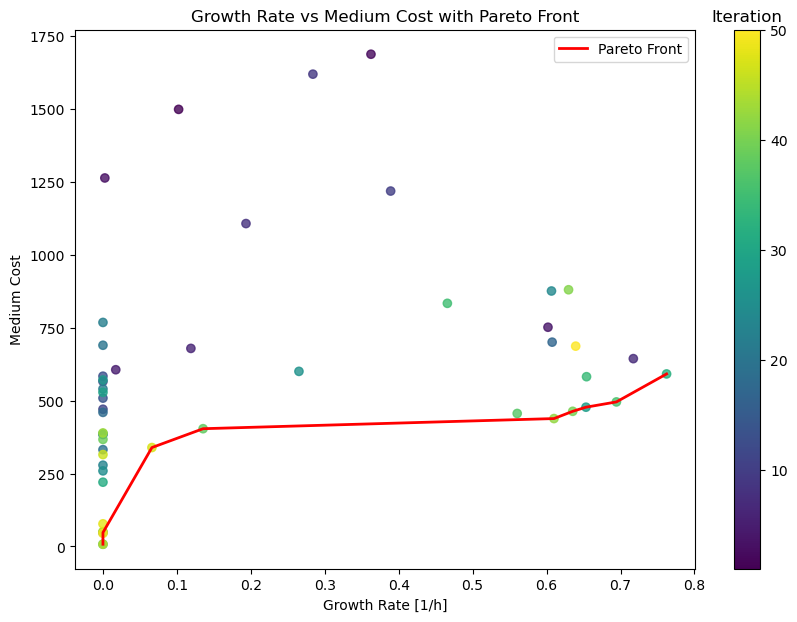

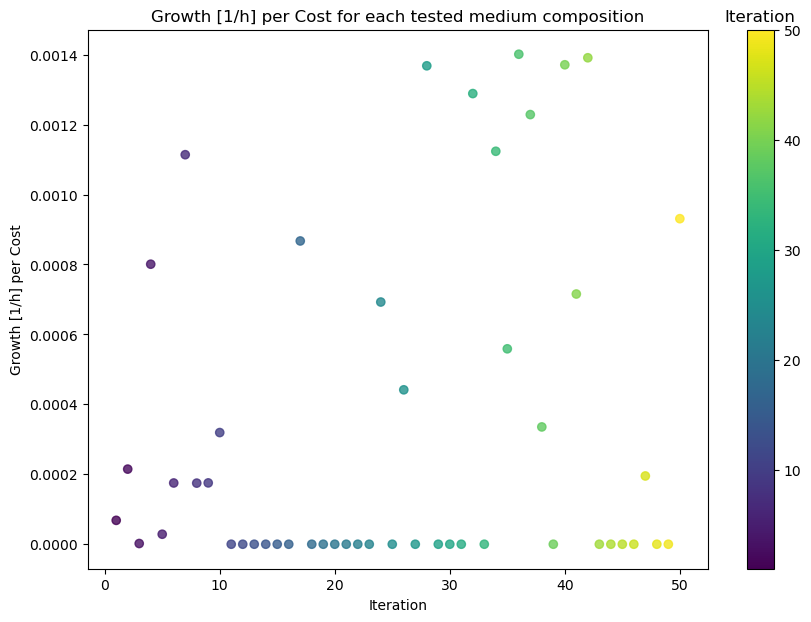

In [13]:
rounds = 1
n_iter = 40 # how many media compositions to evaluate; after 150 didn't seem to have converged
iterations = str(n_iter)

'''iML1515'''
print("Running iML1515 model with M9 medium.")
for r in range(rounds):
    print("Round:\t", r+1, "of ", rounds)
    results_iML1515_M9 = media_BayesOpt(
        model_iML1515, 
        medium = medium_iML1515_M9, bounds = bounds_iML1515_M9, costs = costs_iML1515_M9,
        n_start= n_start, n_iter = n_iter)
    
    # Convert the tensors to lists for JSON serialisation
    results_json_comp = copy.deepcopy(results_iML1515_M9) # make deep copy so that results stays unaffected
    results_json_comp["growth rate tensors"] = results_json_comp["growth rate tensors"].tolist()
    results_json_comp["growth rate list"] = results_json_comp.pop("growth rate tensors") # change name of dictionary key
    results_json_comp["cost tensor"] = results_json_comp["cost tensor"].tolist()
    results_json_comp["cost list"] = results_json_comp.pop("cost tensor") # change name of dictionary key
    results_json_comp["is pareto"] = results_json_comp["is pareto"].tolist()
    
    # convert into json and save as file
    runde = str(r+1)
    name = date + "_BayesOpt_Noiseless_iML1515_M9_" + iterations + "it_round" + runde + ".json"
    with open(name, 'w') as f: 
        json.dump(results_json_comp, f, indent=2) # indent for readability
    
    # Delete the results_json_comp to free up memory
    del results_json_comp

    # plot
    plot_pareto(results_iML1515_M9, (date + "_BayesOpt_Noiseless_iML1515_M9_" + iterations + "it_pareto_round" + runde + ".png"))
    plot_growth_per_cost(results_iML1515_M9, (date + "_BayesOpt_Noiseless_iML1515_M9_" + iterations + "it_growthcost_round" + runde + ".png"))